validationを修正し、先週試した内容をもう一度評価する

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import gc
import pickle
import matplotlib.pyplot as plt

gc.enable()

dtypes = {
    'MachineIdentifier':                                    'object',
    'ProductName':                                          'object',
    'EngineVersion':                                        'object',
    'AppVersion':                                           'object',
    'AvSigVersion':                                         'object',
    'IsBeta':                                               'int8',
    'RtpStateBitfield':                                     'float16',
    'IsSxsPassiveMode':                                     'int8',
    'DefaultBrowsersIdentifier':                            'float32',  # was 'float16'
    'AVProductStatesIdentifier':                            'float32',
    'AVProductsInstalled':                                  'float16',
    'AVProductsEnabled':                                    'float16',
    'HasTpm':                                               'int8',
    'CountryIdentifier':                                    'int16',
    'CityIdentifier':                                       'float32',
    'OrganizationIdentifier':                               'float16',
    'GeoNameIdentifier':                                    'float16',
    'LocaleEnglishNameIdentifier':                          'int16',  # was 'int8'
    'Platform':                                             'object',
    'Processor':                                            'object',
    'OsVer':                                                'object',
    'OsBuild':                                              'int16',
    'OsSuite':                                              'int16',
    'OsPlatformSubRelease':                                 'object',
    'OsBuildLab':                                           'object',
    'SkuEdition':                                           'object',
    'IsProtected':                                          'float16',
    'AutoSampleOptIn':                                      'int8',
    'PuaMode':                                              'object',
    'SMode':                                                'float16',
    'IeVerIdentifier':                                      'float16',
    'SmartScreen':                                          'object',
    'Firewall':                                             'float16',
    'UacLuaenable':                                         'float64', # was 'float32'
    'Census_MDC2FormFactor':                                'object',
    'Census_DeviceFamily':                                  'object',
    'Census_OEMNameIdentifier':                             'float32', # was 'float16'
    'Census_OEMModelIdentifier':                            'float32',
    'Census_ProcessorCoreCount':                            'float16',
    'Census_ProcessorManufacturerIdentifier':               'float16',
    'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
    'Census_ProcessorClass':                                'object',
    'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
    'Census_PrimaryDiskTypeName':                           'object',
    'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
    'Census_HasOpticalDiskDrive':                           'int8',
    'Census_TotalPhysicalRAM':                              'float32',
    'Census_ChassisTypeName':                               'object',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
    'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
    'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
    'Census_PowerPlatformRoleName':                         'object',
    'Census_InternalBatteryType':                           'object',
    'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
    'Census_OSVersion':                                     'object',
    'Census_OSArchitecture':                                'object',
    'Census_OSBranch':                                      'object',
    'Census_OSBuildNumber':                                 'int16',
    'Census_OSBuildRevision':                               'int32',
    'Census_OSEdition':                                     'object',
    'Census_OSSkuName':                                     'object',
    'Census_OSInstallTypeName':                             'object',
    'Census_OSInstallLanguageIdentifier':                   'float16',
    'Census_OSUILocaleIdentifier':                          'int16',
    'Census_OSWUAutoUpdateOptionsName':                     'object',
    'Census_IsPortableOperatingSystem':                     'int8',
    'Census_GenuineStateName':                              'object',
    'Census_ActivationChannel':                             'object',
    'Census_IsFlightingInternal':                           'float16',
    'Census_IsFlightsDisabled':                             'float16',
    'Census_FlightRing':                                    'object',
    'Census_ThresholdOptIn':                                'float16',
    'Census_FirmwareManufacturerIdentifier':                'float16',
    'Census_FirmwareVersionIdentifier':                     'float32',
    'Census_IsSecureBootEnabled':                           'int8',
    'Census_IsWIMBootEnabled':                              'float16',
    'Census_IsVirtualDevice':                               'float16',
    'Census_IsTouchEnabled':                                'int8',
    'Census_IsPenCapable':                                  'int8',
    'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
    'Wdft_IsGamer':                                         'float16',
    'Wdft_RegionIdentifier':                                'float16',
    'HasDetections':                                        'float32',
    }

In [13]:
# cpmp_auc
from numba import jit

@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

まずはnumeric

In [3]:
#データ読みこみ
with open('/home/um003580/code/0307/train_preprocess.csv.pkl','rb') as f:
  train = pickle.load(f)
with open('/home/um003580/code/0307/test_preprocess.csv.pkl','rb') as f:
  test = pickle.load(f)

In [5]:
train.head()

MachineIdentifier ProductName EngineVersion AppVersion AvSigVersion IsBeta  \
0                  0           5             0          0            0      1   
1                  1           5            57         30         6465      1   
2                  2           5             0          0            0      1   
3                  3           5             0          0            0      1   
4                  4           5             0          0            0      1   

  RtpStateBitfield IsSxsPassiveMode DefaultBrowsersIdentifier  \
0                7                1                      2610   
1                7                1                      2610   
2                7                1                      2610   
3                7                1                      2610   
4                7                1                      2610   

  AVProductStatesIdentifier      ...      Census_OSVersion2 Census_OSVersion3  \
0                     26978      ...                      0             17134   
1                     26978      ...                      0             17134   
2                     26978      ...                      0             17134   
3                     26978      ...                      0             17134   
4                     26978      ...                      0             17134   

  Census_OSVersion4 OsBuildLab_1 OsBuildLab_2 OsBuildLab_3 OsBuildLab_4  \
0                 0           35            2            2           17   
1                 1           35            2            2           17   
2                 0           35            2            2           17   
3                 0           35            2            2           17   
4                 0           35            2            2           17   

  OsBuildLab_5_1 OsBuildLab_5_2 HasDetections  
0            230            180           0.0  
1            230            180           0.0  
2            230            180           0.0  
3            230            180           1.0  
4            230            180           1.0  

[5 rows x 105 columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921483 entries, 0 to 8921482
Columns: 105 entries, MachineIdentifier to HasDetections
dtypes: category(95), float16(1), float32(5), float64(3), uint64(1)
memory usage: 1.4 GB


In [7]:
obl = ['OsBuildLab_1','OsBuildLab_2','OsBuildLab_3','OsBuildLab_4','OsBuildLab_5_1','OsBuildLab_5_2']
cols = [x for x in train.columns if x not in obl]

In [12]:
cols.remove('MachineIdentifier')
cols.remove('HasDetections')

In [8]:
with open('/home/um003580/code/03052/train_index.pkl','rb') as f:
  train_index = pickle.load(f)
with open('/home/um003580/code/03052/valid_index.pkl','rb') as f:
  valid_index = pickle.load(f)

In [32]:
# not categorical features to numeric features
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[cols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[cols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.662114
[40]	valid_0's auc: 0.678079
[60]	valid_0's auc: 0.688469
[80]	valid_0's auc: 0.691364
[100]	valid_0's auc: 0.693479
[120]	valid_0's auc: 0.694764
[140]	valid_0's auc: 0.695412
[160]	valid_0's auc: 0.696034
[180]	valid_0's auc: 0.696733
[200]	valid_0's auc: 0.697124
[220]	valid_0's auc: 0.697609
[240]	valid_0's auc: 0.698012
[260]	valid_0's auc: 0.698409
[280]	valid_0's auc: 0.698937
[300]	valid_0's auc: 0.699156
[320]	valid_0's auc: 0.699317
[340]	valid_0's auc: 0.699585
[360]	valid_0's auc: 0.699849
[380]	valid_0's auc: 0.699948
[400]	valid_0's auc: 0.700033
[420]	valid_0's auc: 0.700168
[440]	valid_0's auc: 0.700323
[460]	valid_0's auc: 0.700475
[480]	valid_0's auc: 0.700628
[500]	valid_0's auc: 0.700806
[520]	valid_0's auc: 0.700866
[540]	valid_0's auc: 0.700908
[560]	valid_0's auc: 0.701027
[580]	valid_0's auc: 0.701078
[600]	valid_0's auc: 0.701142
[620]	valid_0's auc: 0.701167
[640]	valid

Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

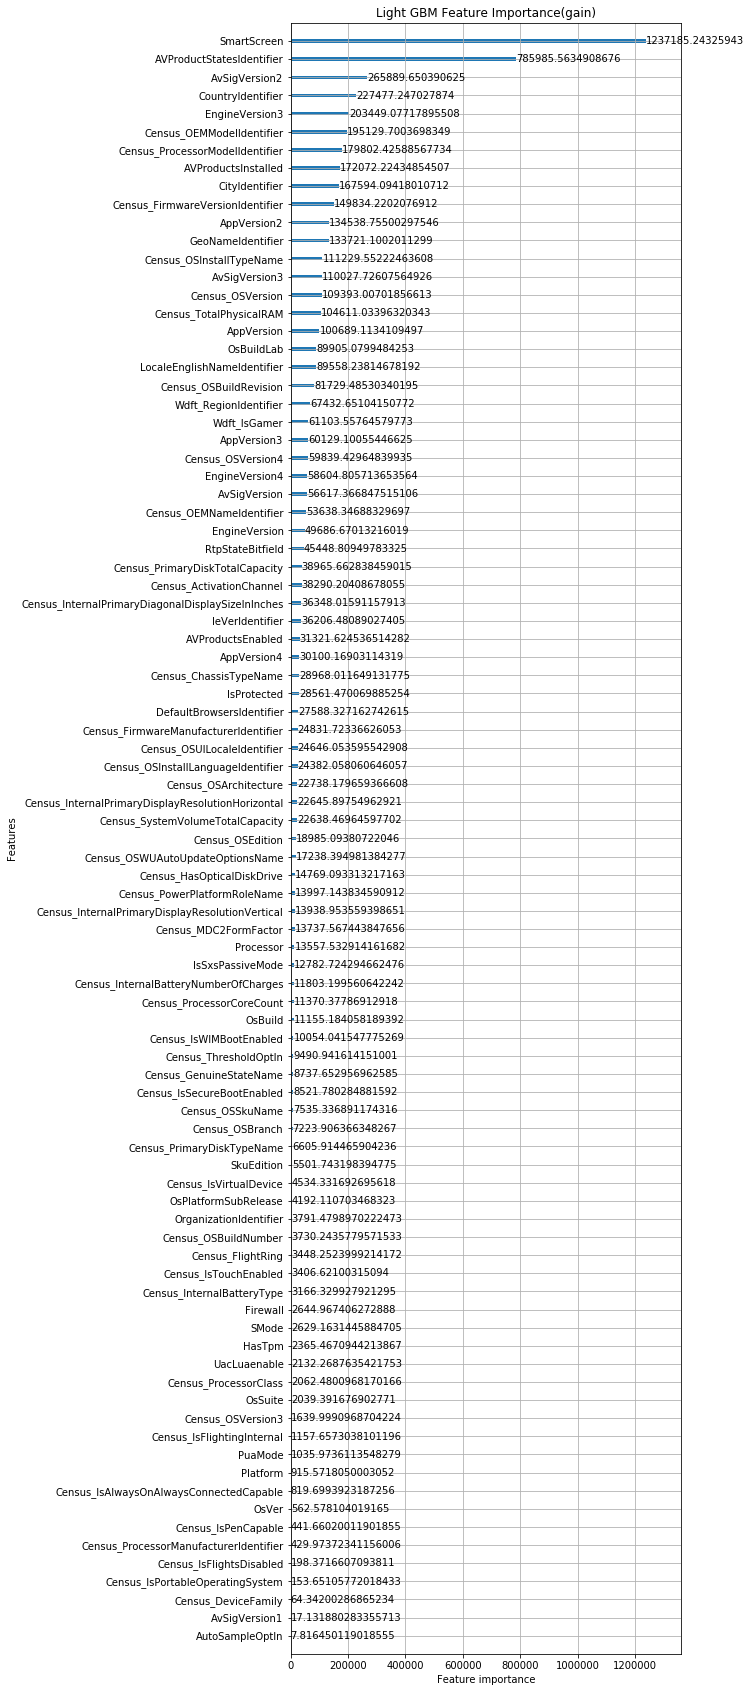

In [33]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [42]:
# lr=0.2で実行
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[cols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[cols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.673311
[40]	valid_0's auc: 0.687781
[60]	valid_0's auc: 0.693172
[80]	valid_0's auc: 0.695325
[100]	valid_0's auc: 0.6966
[120]	valid_0's auc: 0.697114
[140]	valid_0's auc: 0.697697
[160]	valid_0's auc: 0.698291
[180]	valid_0's auc: 0.699105
[200]	valid_0's auc: 0.699302
[220]	valid_0's auc: 0.699697
[240]	valid_0's auc: 0.699844
[260]	valid_0's auc: 0.699796
[280]	valid_0's auc: 0.699719
[300]	valid_0's auc: 0.69986
[320]	valid_0's auc: 0.700025
[340]	valid_0's auc: 0.700347
[360]	valid_0's auc: 0.700453
[380]	valid_0's auc: 0.700556
[400]	valid_0's auc: 0.700536
[420]	valid_0's auc: 0.700523
[440]	valid_0's auc: 0.7006
[460]	valid_0's auc: 0.699717
[480]	valid_0's auc: 0.699686
[500]	valid_0's auc: 0.699611
[520]	valid_0's auc: 0.699673
[540]	valid_0's auc: 0.699747
Early stopping, best iteration is:
[442]	valid_0's auc: 0.70089


In [14]:
with open('/home/um003580/code/03062/train_count.csv.pkl','rb') as f:
  train_count = pickle.load(f)
with open('/home/um003580/code/03062/test_count.csv.pkl','rb') as f:
  test_count = pickle.load(f)

In [16]:
train_count['SmartScreen_count'].head()

0          NaN
1          NaN
2    7729743.0
3    1646629.0
4    7729743.0
Name: SmartScreen_count, dtype: float64

In [17]:
train = pd.merge(train, train_count, on='MachineIdentifier', how='left')
test = pd.merge(test, test_count, on='MachineIdentifier', how='left')

In [18]:
train.head()

MachineIdentifier ProductName EngineVersion AppVersion AvSigVersion IsBeta  \
0                  0           5             0          0            0      1   
1                  1           5            57         30         6465      1   
2                  2           5             0          0            0      1   
3                  3           5             0          0            0      1   
4                  4           5             0          0            0      1   

  RtpStateBitfield IsSxsPassiveMode DefaultBrowsersIdentifier  \
0                7                1                      2610   
1                7                1                      2610   
2                7                1                      2610   
3                7                1                      2610   
4                7                1                      2610   

  AVProductStatesIdentifier         ...          Census_OSVersion1_count  \
0                     26978         ...                         16774689   
1                     26978         ...                         16774689   
2                     26978         ...                         16774689   
3                     26978         ...                         16774689   
4                     26978         ...                         16774689   

  Census_OSVersion2_count Census_OSVersion3_count Census_OSVersion4_count  \
0                16774689                 7987759                  959932   
1                16774689                 7987759                  285590   
2                16774689                 7987759                  959932   
3                16774689                 7987759                 1565473   
4                16774689                 7987759                  252155   

  OsBuildLab_1_count OsBuildLab_2_count OsBuildLab_3_count OsBuildLab_4_count  \
0            7808674            8099217           15278759            7808682   
1            7808674            8099217           15278759            7808682   
2            7808674            8099217           15278759            7808682   
3            7808674            8099217           15278759            7808682   
4            7808674            8099217           15278759            7808682   

  OsBuildLab_5_1_count OsBuildLab_5_2_count  
0              7819574              7814547  
1              7819574              7814547  
2              7819574              7814547  
3              7819574              7814547  
4              7819574              7814547  

[5 rows x 204 columns]

In [19]:
cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [20]:
cols2 = [x for x in train.columns if x in train.columns[train.columns.str.endswith('_count')]]

In [21]:
cols2

['ProductName_count',
 'EngineVersion_count',
 'AppVersion_count',
 'AvSigVersion_count',
 'IsBeta_count',
 'RtpStateBitfield_count',
 'IsSxsPassiveMode_count',
 'DefaultBrowsersIdentifier_count',
 'AVProductStatesIdentifier_count',
 'AVProductsInstalled_count',
 'AVProductsEnabled_count',
 'HasTpm_count',
 'CountryIdentifier_count',
 'CityIdentifier_count',
 'OrganizationIdentifier_count',
 'GeoNameIdentifier_count',
 'LocaleEnglishNameIdentifier_count',
 'Platform_count',
 'Processor_count',
 'OsVer_count',
 'OsBuild_count',
 'OsSuite_count',
 'OsPlatformSubRelease_count',
 'OsBuildLab_count',
 'SkuEdition_count',
 'IsProtected_count',
 'AutoSampleOptIn_count',
 'PuaMode_count',
 'SMode_count',
 'IeVerIdentifier_count',
 'SmartScreen_count',
 'Firewall_count',
 'UacLuaenable_count',
 'Census_MDC2FormFactor_count',
 'Census_DeviceFamily_count',
 'Census_OEMNameIdentifier_count',
 'Census_OEMModelIdentifier_count',
 'Census_ProcessorCoreCount_count',
 'Census_ProcessorManufacturerIdent

In [24]:
usecols = cols + cols2

In [25]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [26]:
# del train['MachineIdentifier'], test['MachineIdentifier']
# gc.collect()

X_fit = train.loc[train_index]
y_fit = X_fit['HasDetections']
del X_fit['HasDetections']

X_val = train.loc[valid_index]
y_val = X_val['HasDetections']
del X_val['HasDetections']

In [28]:
# add all count
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.676986
[40]	valid_0's auc: 0.686779
[60]	valid_0's auc: 0.690588
[80]	valid_0's auc: 0.693622
[100]	valid_0's auc: 0.695268
[120]	valid_0's auc: 0.696462
[140]	valid_0's auc: 0.6974
[160]	valid_0's auc: 0.697956
[180]	valid_0's auc: 0.69833
[200]	valid_0's auc: 0.698991
[220]	valid_0's auc: 0.699454
[240]	valid_0's auc: 0.699741
[260]	valid_0's auc: 0.699285
[280]	valid_0's auc: 0.699546
[300]	valid_0's auc: 0.699687
[320]	valid_0's auc: 0.699715
[340]	valid_0's auc: 0.699763
[360]	valid_0's auc: 0.699233
[380]	valid_0's auc: 0.699213
[400]	valid_0's auc: 0.699404
[420]	valid_0's auc: 0.699563
Early stopping, best iteration is:
[327]	valid_0's auc: 0.69979


In [29]:
usecols = cols + ['CountryIdentifier_count', 'Wdft_RegionIdentifier_count', 'Census_OSBranch_count']
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [30]:
# add ['CountryIdentifier_count', 'Wdft_RegionIdentifier_count', 'Census_OSBranch_count']
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.658409
[40]	valid_0's auc: 0.67367
[60]	valid_0's auc: 0.686715
[80]	valid_0's auc: 0.689609
[100]	valid_0's auc: 0.692335
[120]	valid_0's auc: 0.693939
[140]	valid_0's auc: 0.695294
[160]	valid_0's auc: 0.696033
[180]	valid_0's auc: 0.696225
[200]	valid_0's auc: 0.697006
[220]	valid_0's auc: 0.697689
[240]	valid_0's auc: 0.698126
[260]	valid_0's auc: 0.698292
[280]	valid_0's auc: 0.698685
[300]	valid_0's auc: 0.698863
[320]	valid_0's auc: 0.698934
[340]	valid_0's auc: 0.698661
[360]	valid_0's auc: 0.698892
[380]	valid_0's auc: 0.699042
[400]	valid_0's auc: 0.699203
[420]	valid_0's auc: 0.699473
[440]	valid_0's auc: 0.699798
[460]	valid_0's auc: 0.699896
[480]	valid_0's auc: 0.70005
[500]	valid_0's auc: 0.700339
[520]	valid_0's auc: 0.700555
[540]	valid_0's auc: 0.700042
[560]	valid_0's auc: 0.700115
[580]	valid_0's auc: 0.700096
[600]	valid_0's auc: 0.700146
[620]	valid_0's auc: 0.700136
Early stoppin

Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

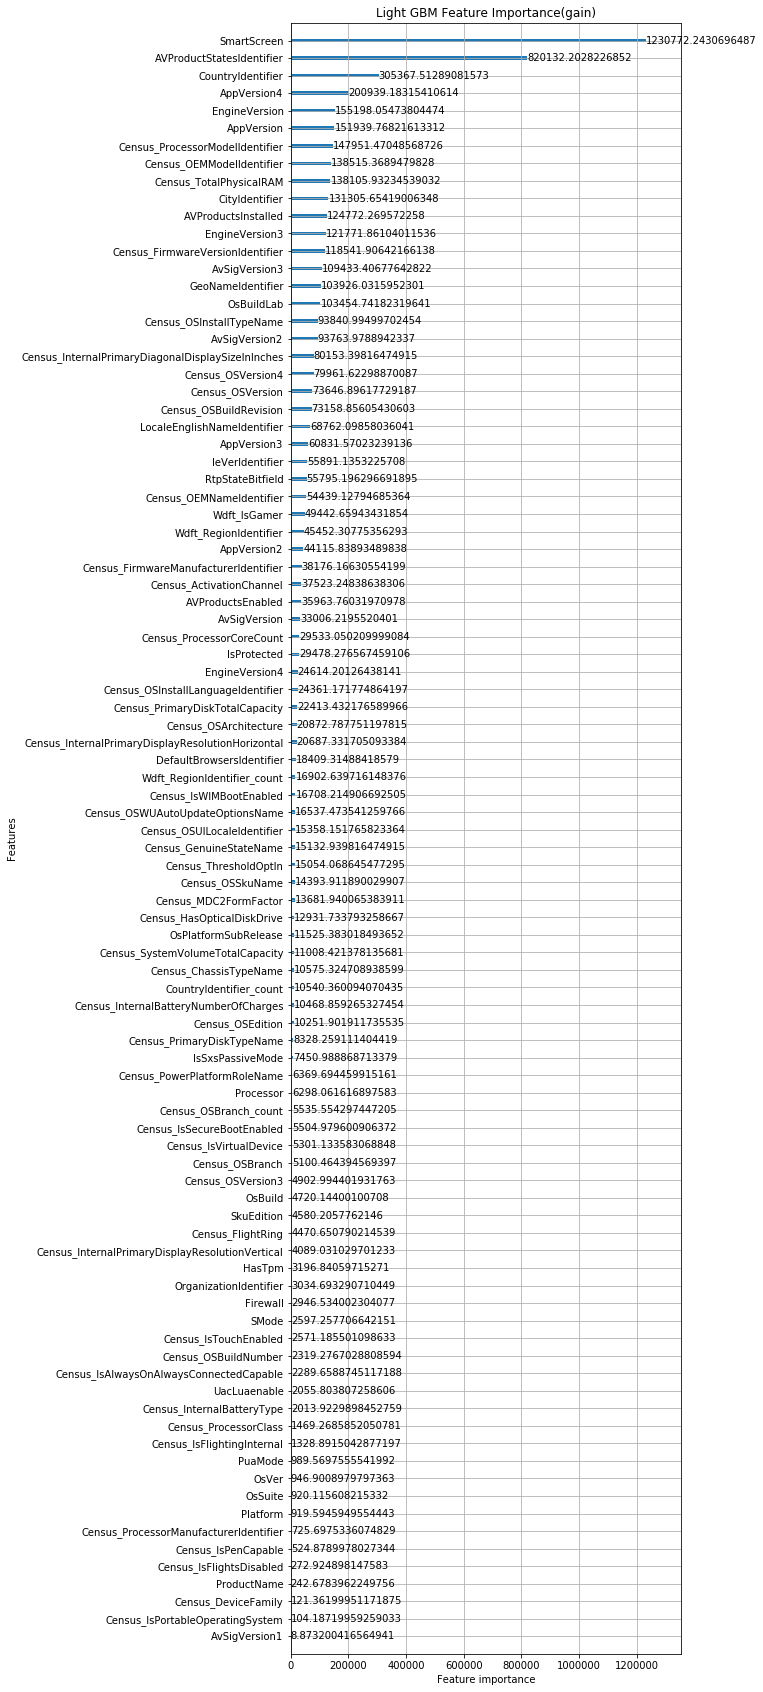

In [31]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [38]:
usecols = cols + ['AVProductStatesIdentifier_count']
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [39]:
# add ['AVProductStatesIdentifier_count']
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.669586
[40]	valid_0's auc: 0.680866
[60]	valid_0's auc: 0.685419
[80]	valid_0's auc: 0.687962
[100]	valid_0's auc: 0.691315
[120]	valid_0's auc: 0.693057
[140]	valid_0's auc: 0.694242
[160]	valid_0's auc: 0.694572
[180]	valid_0's auc: 0.695247
[200]	valid_0's auc: 0.695844
[220]	valid_0's auc: 0.696464
[240]	valid_0's auc: 0.696668
[260]	valid_0's auc: 0.69695
[280]	valid_0's auc: 0.697123
[300]	valid_0's auc: 0.697496
[320]	valid_0's auc: 0.697675
[340]	valid_0's auc: 0.697897
[360]	valid_0's auc: 0.69805
[380]	valid_0's auc: 0.698201
[400]	valid_0's auc: 0.698387
[420]	valid_0's auc: 0.698577
[440]	valid_0's auc: 0.698402
[460]	valid_0's auc: 0.698521
[480]	valid_0's auc: 0.698631
[500]	valid_0's auc: 0.698696
[520]	valid_0's auc: 0.698461
Early stopping, best iteration is:
[432]	valid_0's auc: 0.698722


Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

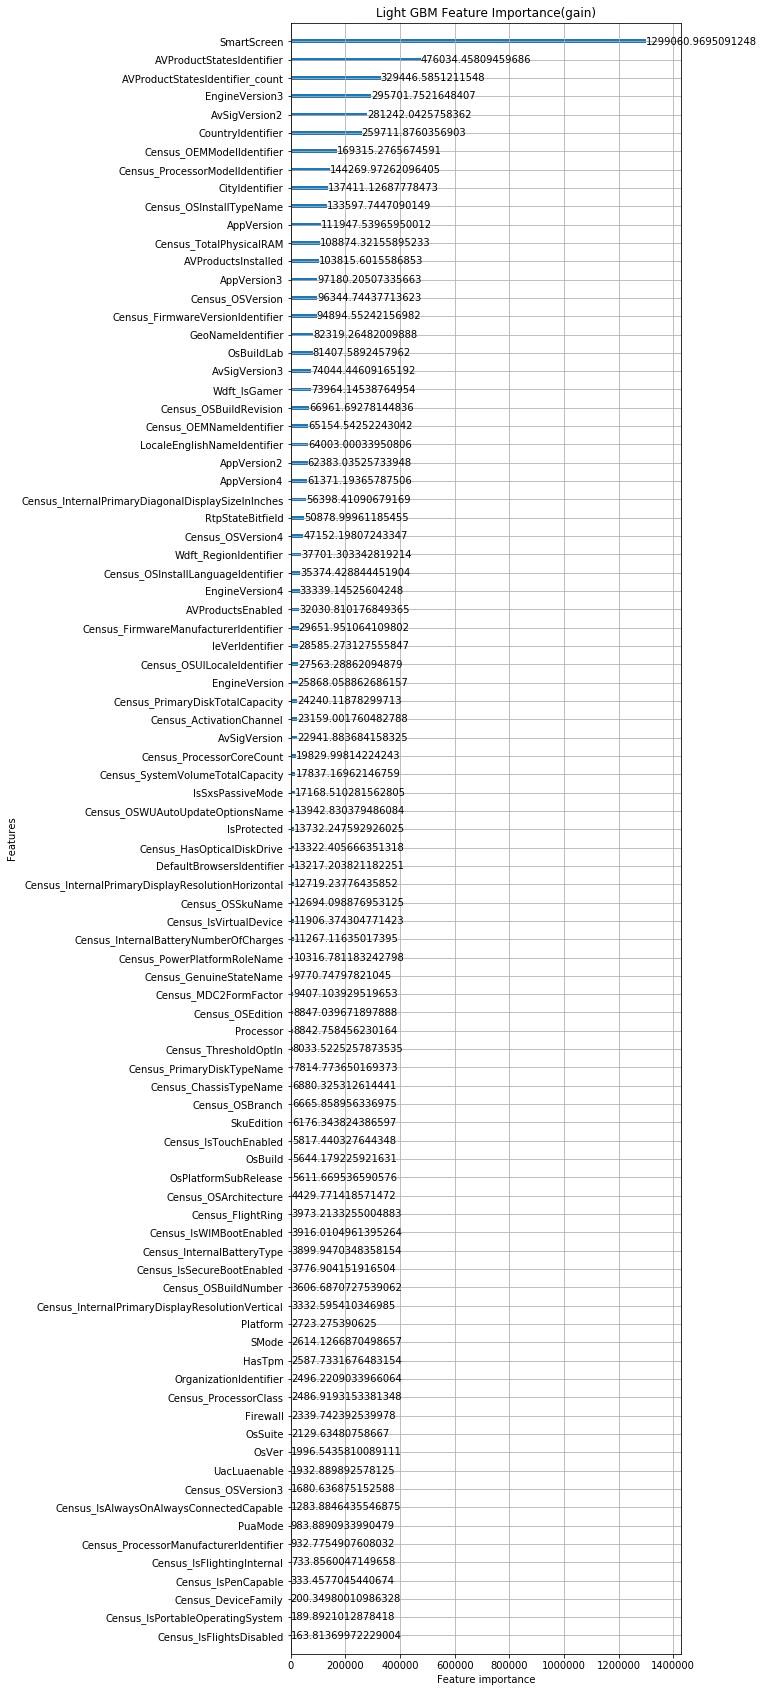

In [40]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [46]:
usecols = cols + ['AvSigVersion2_count', 'EngineVersion3_count']

In [47]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [48]:
# add ['AvSigVersion2_count', 'EngineVersion3_count']
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.684563
[40]	valid_0's auc: 0.691634
[60]	valid_0's auc: 0.694667
[80]	valid_0's auc: 0.696503
[100]	valid_0's auc: 0.697486
[120]	valid_0's auc: 0.697988
[140]	valid_0's auc: 0.698502
[160]	valid_0's auc: 0.699128
[180]	valid_0's auc: 0.699371
[200]	valid_0's auc: 0.699609
[220]	valid_0's auc: 0.699804
[240]	valid_0's auc: 0.698268
[260]	valid_0's auc: 0.698253
[280]	valid_0's auc: 0.698844
[300]	valid_0's auc: 0.699192
Early stopping, best iteration is:
[216]	valid_0's auc: 0.699819


In [49]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.677966
[40]	valid_0's auc: 0.683036
[60]	valid_0's auc: 0.687109
[80]	valid_0's auc: 0.689589
[100]	valid_0's auc: 0.691229
[120]	valid_0's auc: 0.692179
[140]	valid_0's auc: 0.693481
[160]	valid_0's auc: 0.694699
[180]	valid_0's auc: 0.695439
[200]	valid_0's auc: 0.695878
[220]	valid_0's auc: 0.695961
[240]	valid_0's auc: 0.696124
[260]	valid_0's auc: 0.696434
[280]	valid_0's auc: 0.696637
[300]	valid_0's auc: 0.696802
[320]	valid_0's auc: 0.696948
[340]	valid_0's auc: 0.697141
[360]	valid_0's auc: 0.697479
[380]	valid_0's auc: 0.697628
[400]	valid_0's auc: 0.697802
[420]	valid_0's auc: 0.698126
[440]	valid_0's auc: 0.698175
[460]	valid_0's auc: 0.698252
[480]	valid_0's auc: 0.698436
[500]	valid_0's auc: 0.698548
[520]	valid_0's auc: 0.698604
[540]	valid_0's auc: 0.698691
[560]	valid_0's auc: 0.698795
[580]	valid_0's auc: 0.698889
[600]	valid_0's auc: 0.69869
[620]	valid_0's auc: 0.698744
[640]	valid_

Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

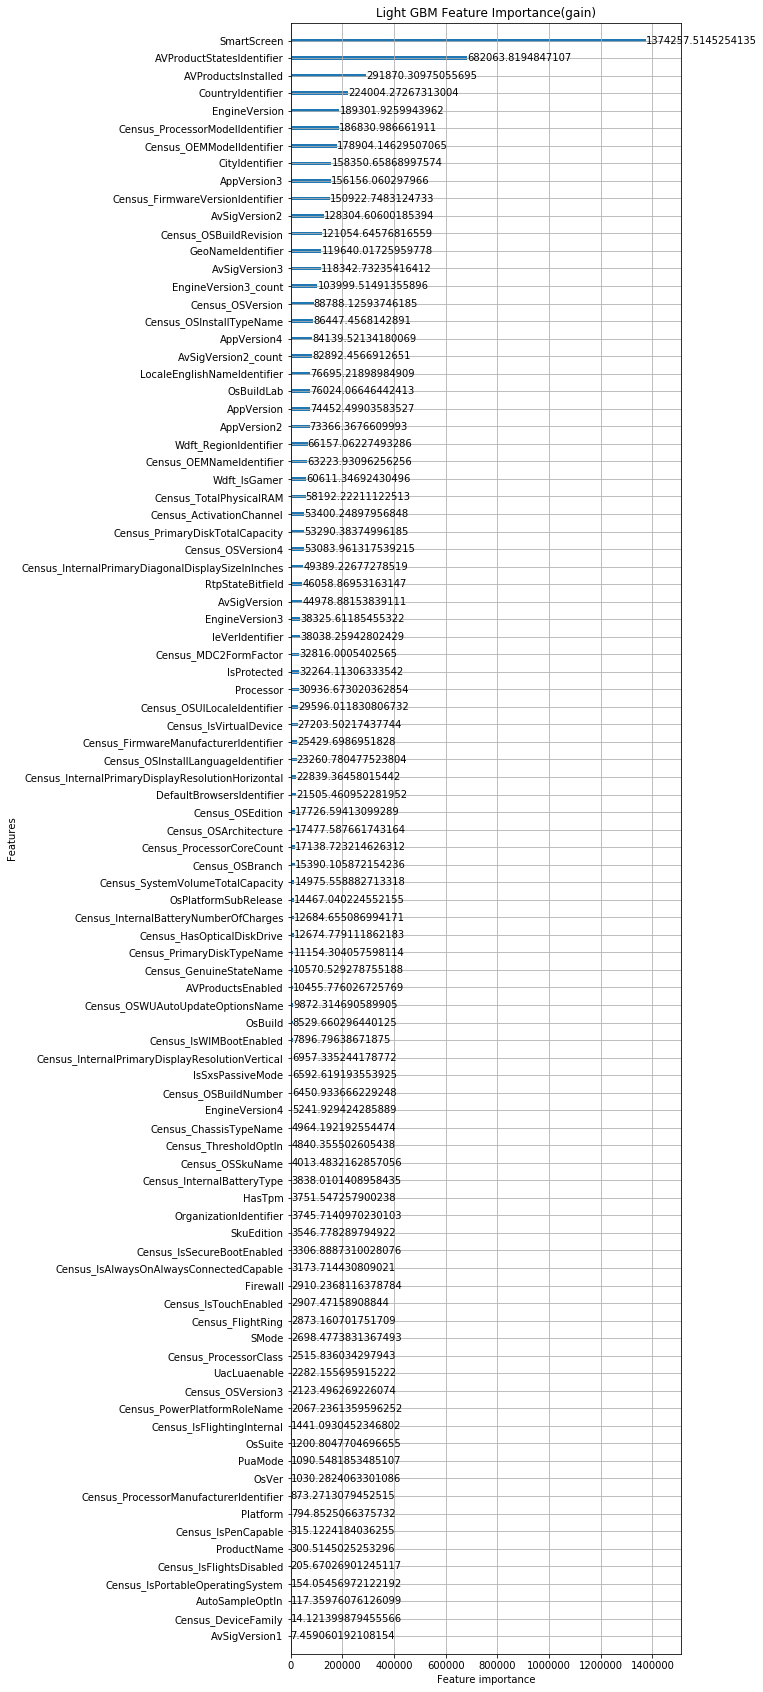

In [50]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [51]:
usecols = cols + ['Census_OEMModelIdentifier_count','Census_ProcessorModelIdentifier_count']

In [52]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [53]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.683552
[40]	valid_0's auc: 0.689948
[60]	valid_0's auc: 0.693193
[80]	valid_0's auc: 0.695148
[100]	valid_0's auc: 0.696482
[120]	valid_0's auc: 0.696947
[140]	valid_0's auc: 0.697218
[160]	valid_0's auc: 0.697612
[180]	valid_0's auc: 0.69798
[200]	valid_0's auc: 0.698205
[220]	valid_0's auc: 0.698441
[240]	valid_0's auc: 0.698415
[260]	valid_0's auc: 0.69869
[280]	valid_0's auc: 0.698981
[300]	valid_0's auc: 0.699134
[320]	valid_0's auc: 0.699354
[340]	valid_0's auc: 0.699488
[360]	valid_0's auc: 0.699533
[380]	valid_0's auc: 0.69975
[400]	valid_0's auc: 0.699854
[420]	valid_0's auc: 0.69952
[440]	valid_0's auc: 0.699505
[460]	valid_0's auc: 0.699439
[480]	valid_0's auc: 0.69943
[500]	valid_0's auc: 0.699473
Early stopping, best iteration is:
[401]	valid_0's auc: 0.699893


Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

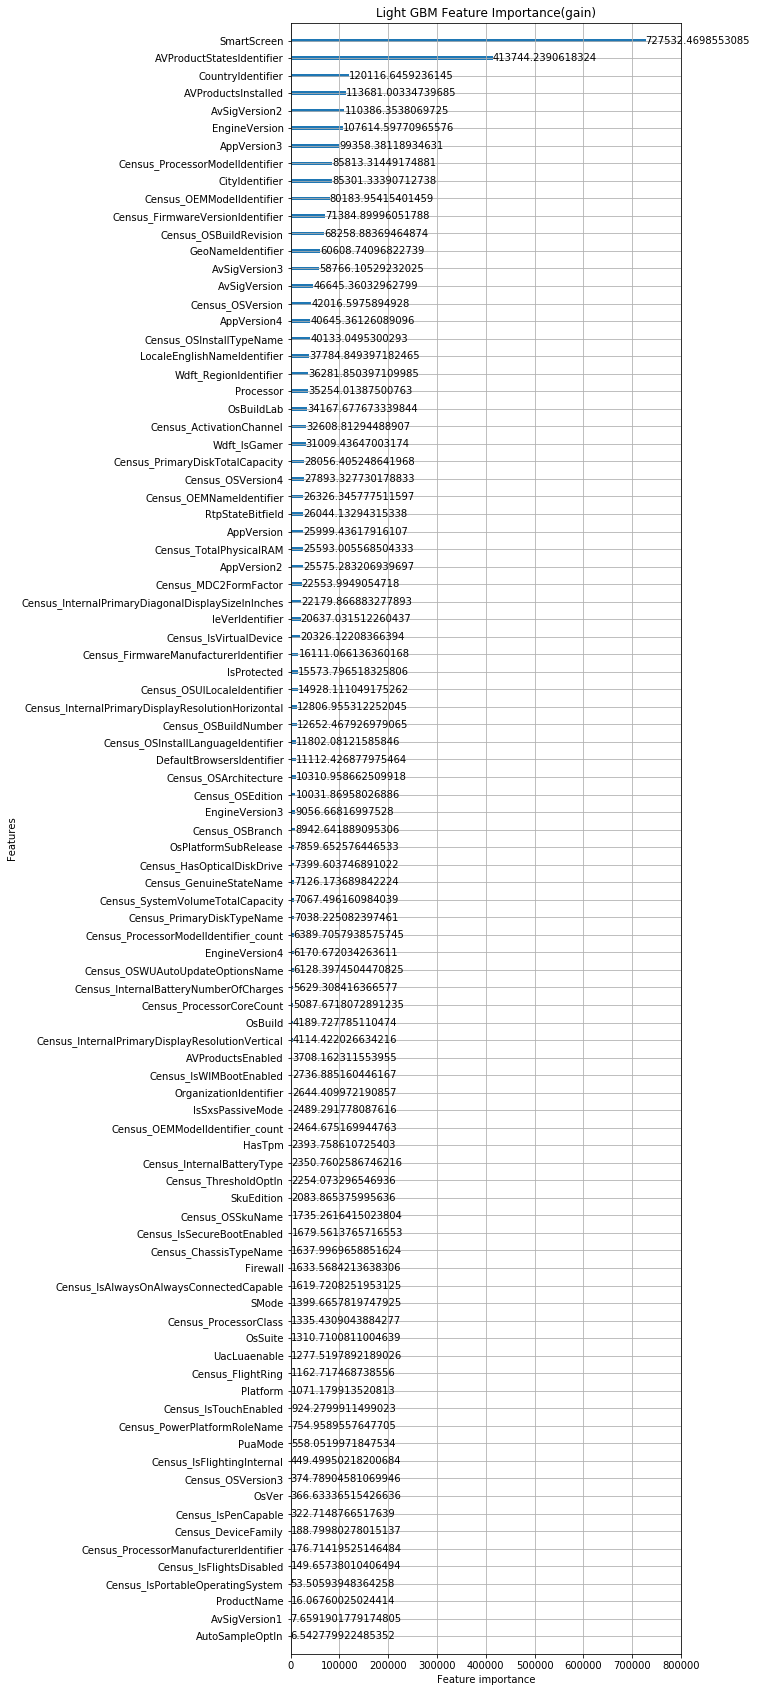

In [54]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [55]:
usecols = cols + ['AVProductsInstalled_count','CityIdentifier_count','Census_FirmwareVersionIdentifier_count']

In [56]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.672138
[40]	valid_0's auc: 0.685548
[60]	valid_0's auc: 0.692406
[80]	valid_0's auc: 0.69428
[100]	valid_0's auc: 0.695588
[120]	valid_0's auc: 0.695111
[140]	valid_0's auc: 0.695694
[160]	valid_0's auc: 0.69633
[180]	valid_0's auc: 0.696826
[200]	valid_0's auc: 0.697133
[220]	valid_0's auc: 0.697593
[240]	valid_0's auc: 0.69784
[260]	valid_0's auc: 0.698083
[280]	valid_0's auc: 0.698293
[300]	valid_0's auc: 0.698272
[320]	valid_0's auc: 0.698335
[340]	valid_0's auc: 0.698352
[360]	valid_0's auc: 0.698519
[380]	valid_0's auc: 0.698656
[400]	valid_0's auc: 0.698656
[420]	valid_0's auc: 0.698464
[440]	valid_0's auc: 0.698419
[460]	valid_0's auc: 0.69793
Early stopping, best iteration is:
[374]	valid_0's auc: 0.698671


Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

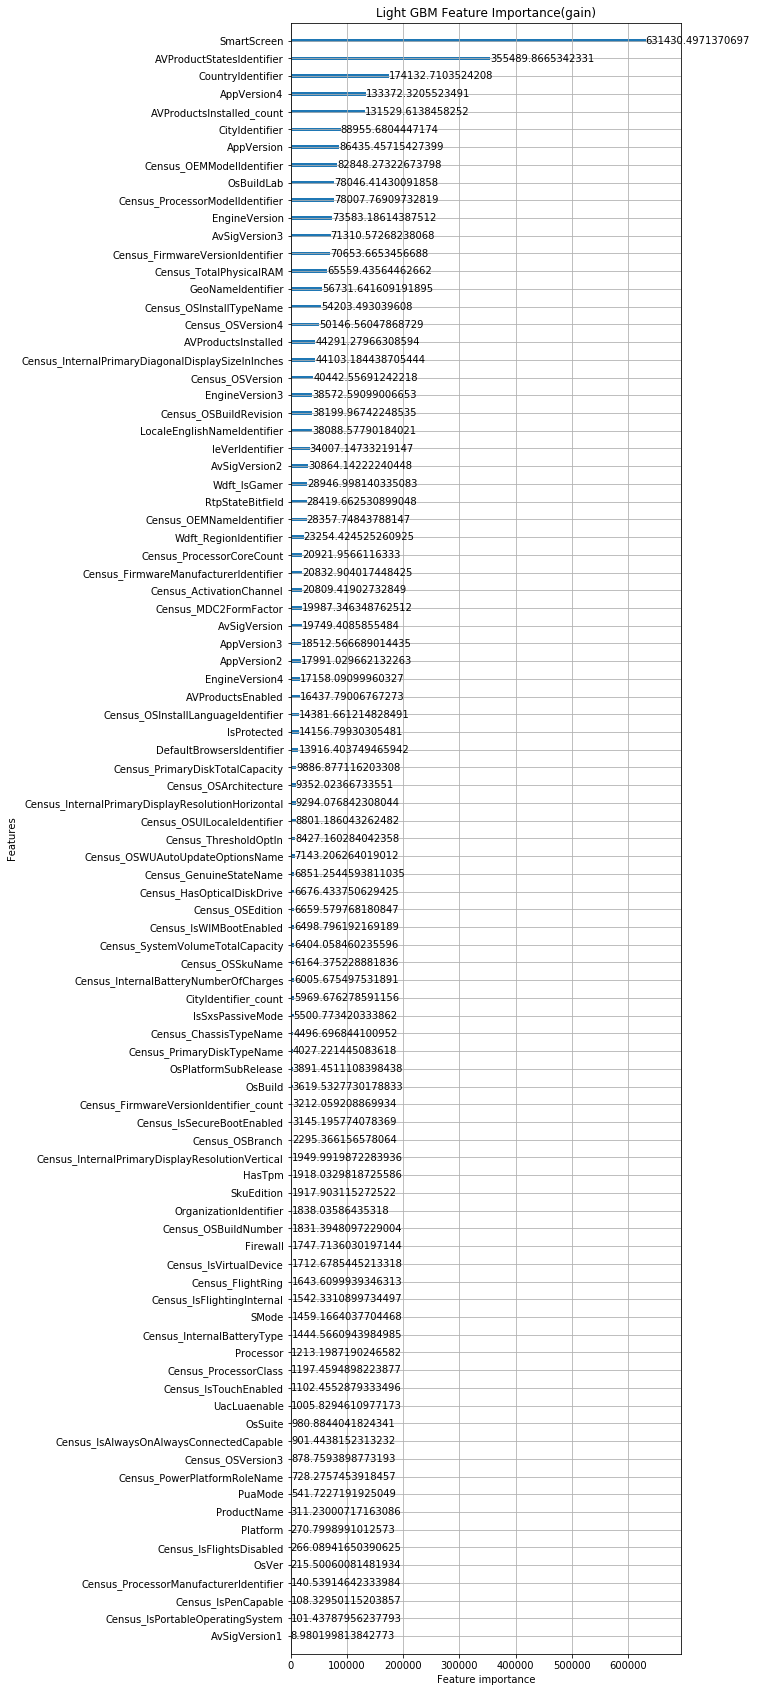

In [57]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [59]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[cols2],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[cols2],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.653097
[40]	valid_0's auc: 0.671284
[60]	valid_0's auc: 0.681234
[80]	valid_0's auc: 0.684609
[100]	valid_0's auc: 0.686931
[120]	valid_0's auc: 0.688291
[140]	valid_0's auc: 0.689555
[160]	valid_0's auc: 0.690373
[180]	valid_0's auc: 0.691364
[200]	valid_0's auc: 0.692168
[220]	valid_0's auc: 0.69288
[240]	valid_0's auc: 0.693168
[260]	valid_0's auc: 0.693321
[280]	valid_0's auc: 0.693735
[300]	valid_0's auc: 0.693797
[320]	valid_0's auc: 0.694033
[340]	valid_0's auc: 0.694133
[360]	valid_0's auc: 0.694361
[380]	valid_0's auc: 0.694506
[400]	valid_0's auc: 0.694684
[420]	valid_0's auc: 0.695067
[440]	valid_0's auc: 0.695275
[460]	valid_0's auc: 0.695534
[480]	valid_0's auc: 0.695681
[500]	valid_0's auc: 0.695884
[520]	valid_0's auc: 0.696175
[540]	valid_0's auc: 0.696403
[560]	valid_0's auc: 0.696472
[580]	valid_0's auc: 0.696442
[600]	valid_0's auc: 0.696495
[620]	valid_0's auc: 0.696515
[640]	valid_

Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

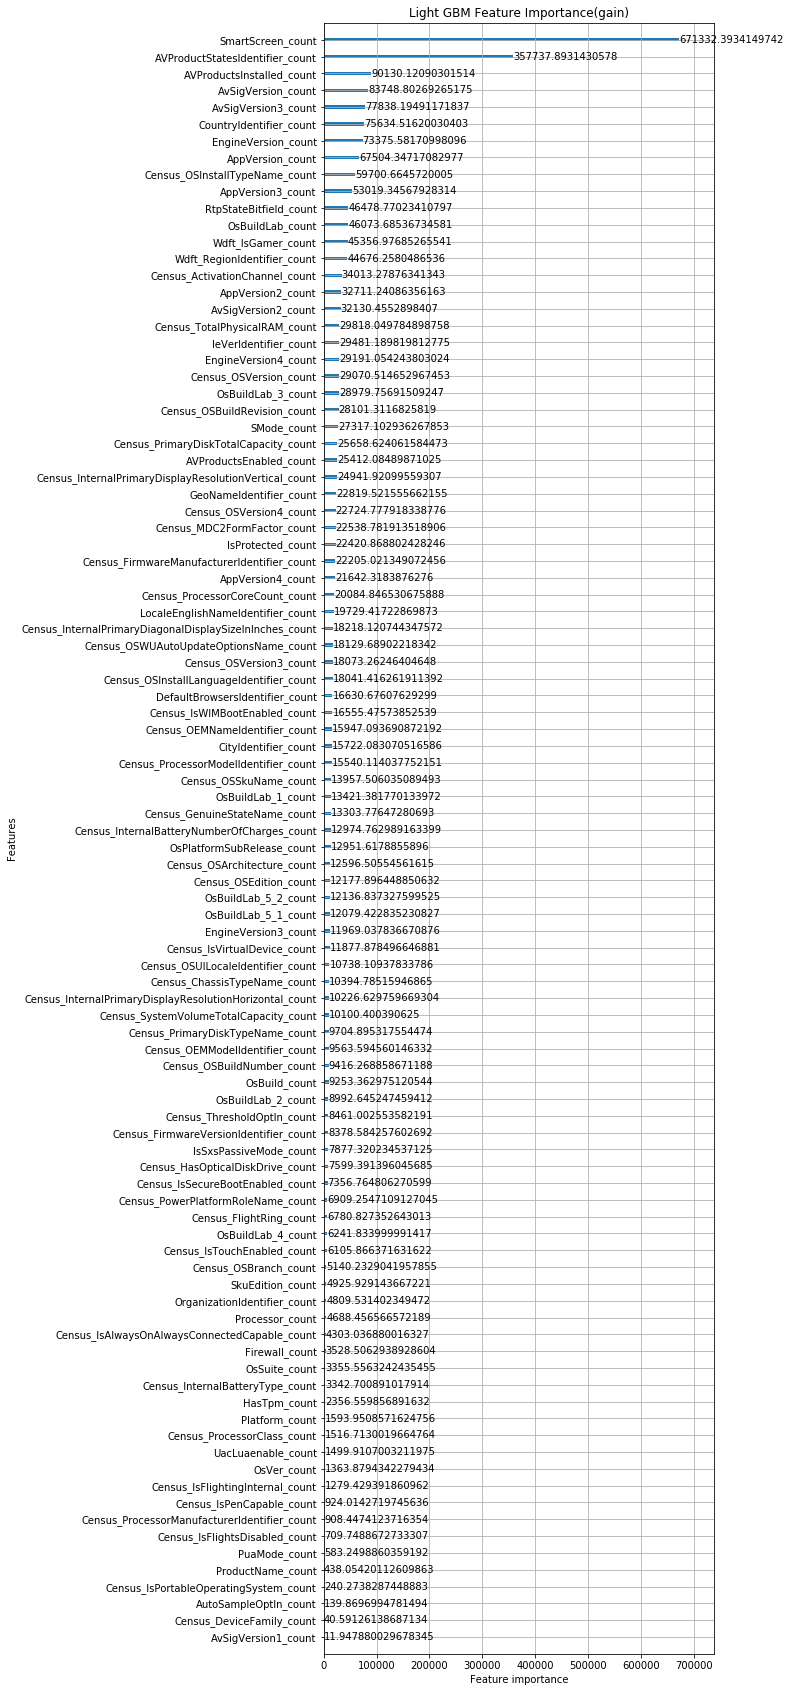

In [60]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [64]:
usecols = cols + ['ProductName_count','OsPlatformSubRelease_count','Census_OSArchitecture_count']

In [65]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [66]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.671842
[40]	valid_0's auc: 0.685368
[60]	valid_0's auc: 0.69262
[80]	valid_0's auc: 0.694628
[100]	valid_0's auc: 0.69581
[120]	valid_0's auc: 0.696479
[140]	valid_0's auc: 0.696973
[160]	valid_0's auc: 0.697483
[180]	valid_0's auc: 0.697529
[200]	valid_0's auc: 0.697604
[220]	valid_0's auc: 0.698098
[240]	valid_0's auc: 0.698498
[260]	valid_0's auc: 0.698777
[280]	valid_0's auc: 0.699038
[300]	valid_0's auc: 0.697345
[320]	valid_0's auc: 0.697384
[340]	valid_0's auc: 0.697675
[360]	valid_0's auc: 0.697867
[380]	valid_0's auc: 0.697925
Early stopping, best iteration is:
[282]	valid_0's auc: 0.699063


In [69]:
usecols = cols + ['Census_OSVersion_count','Census_OSSkuName_count']

In [70]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [71]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.683183
[40]	valid_0's auc: 0.688493
[60]	valid_0's auc: 0.691744
[80]	valid_0's auc: 0.693522
[100]	valid_0's auc: 0.695148
[120]	valid_0's auc: 0.696141
[140]	valid_0's auc: 0.696534
[160]	valid_0's auc: 0.69724
[180]	valid_0's auc: 0.697569
[200]	valid_0's auc: 0.697807
[220]	valid_0's auc: 0.698013
[240]	valid_0's auc: 0.698055
[260]	valid_0's auc: 0.697446
[280]	valid_0's auc: 0.697584
[300]	valid_0's auc: 0.697689
[320]	valid_0's auc: 0.697727
[340]	valid_0's auc: 0.697956
Early stopping, best iteration is:
[256]	valid_0's auc: 0.698359


In [74]:
usecols = cols + ['AvSigVersion_count','EngineVersion_count']

In [75]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.684153
[40]	valid_0's auc: 0.689168
[60]	valid_0's auc: 0.691626
[80]	valid_0's auc: 0.693143
[100]	valid_0's auc: 0.694619
[120]	valid_0's auc: 0.695111
[140]	valid_0's auc: 0.695545
[160]	valid_0's auc: 0.696519
[180]	valid_0's auc: 0.696973
[200]	valid_0's auc: 0.697274
[220]	valid_0's auc: 0.697354
[240]	valid_0's auc: 0.697289
[260]	valid_0's auc: 0.697485
[280]	valid_0's auc: 0.695819
[300]	valid_0's auc: 0.695958
[320]	valid_0's auc: 0.696023
[340]	valid_0's auc: 0.696058
[360]	valid_0's auc: 0.696016
Early stopping, best iteration is:
[267]	valid_0's auc: 0.697682


In [76]:
for df in [train, test]:
    df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
    df['non_primary_drive_MB'] = df['Census_PrimaryDiskTotalCapacity'] - df['Census_SystemVolumeTotalCapacity']

In [77]:
usecols = cols + ['primary_drive_c_ratio','non_primary_drive_MB']

In [78]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [80]:
# del train['MachineIdentifier'], test['MachineIdentifier']
# gc.collect()

X_fit = train.loc[train_index]
# y_fit = X_fit['HasDetections']
del X_fit['HasDetections']

X_val = train.loc[valid_index]
# y_val = X_val['HasDetections']
del X_val['HasDetections']

In [81]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.682575
[40]	valid_0's auc: 0.689514
[60]	valid_0's auc: 0.690951
[80]	valid_0's auc: 0.692962
[100]	valid_0's auc: 0.693299
[120]	valid_0's auc: 0.69446
[140]	valid_0's auc: 0.694737
[160]	valid_0's auc: 0.694827
[180]	valid_0's auc: 0.695268
[200]	valid_0's auc: 0.695783
[220]	valid_0's auc: 0.69592
[240]	valid_0's auc: 0.696045
[260]	valid_0's auc: 0.696283
[280]	valid_0's auc: 0.696586
[300]	valid_0's auc: 0.696745
[320]	valid_0's auc: 0.696592
[340]	valid_0's auc: 0.696606
[360]	valid_0's auc: 0.696769
[380]	valid_0's auc: 0.696814
[400]	valid_0's auc: 0.696637
[420]	valid_0's auc: 0.696844
[440]	valid_0's auc: 0.696843
[460]	valid_0's auc: 0.696916
[480]	valid_0's auc: 0.696928
[500]	valid_0's auc: 0.697047
[520]	valid_0's auc: 0.697055
[540]	valid_0's auc: 0.696971
[560]	valid_0's auc: 0.697029
[580]	valid_0's auc: 0.697116
[600]	valid_0's auc: 0.697111
Early stopping, best iteration is:
[513]	va

In [82]:
for df in [train,test]:
    df['resolution'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']*df['Census_InternalPrimaryDisplayResolutionVertical']
    df['ram_1'] = df['Census_TotalPhysicalRAM'] / df['resolution']
    df['ram_2'] = df['Census_TotalPhysicalRAM'] / df['Census_PrimaryDiskTotalCapacity']
    df['ram_3'] = df['Census_TotalPhysicalRAM'] / df['Census_ProcessorCoreCount']
    df['ram_4'] = df['Census_TotalPhysicalRAM'] / df['Census_SystemVolumeTotalCapacity']
    df['ram_5'] = df['Census_TotalPhysicalRAM'] / df['Census_InternalPrimaryDiagonalDisplaySizeInInches']    

In [83]:
# del train['MachineIdentifier'], test['MachineIdentifier']
# gc.collect()

X_fit = train.loc[train_index]
# y_fit = X_fit['HasDetections']
del X_fit['HasDetections']

X_val = train.loc[valid_index]
# y_val = X_val['HasDetections']
del X_val['HasDetections']

In [84]:
usecols = cols + ['resolution', 'ram_1', 'ram_2', 'ram_3', 'ram_4', 'ram_5']

In [85]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [86]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.678839
[40]	valid_0's auc: 0.686761
[60]	valid_0's auc: 0.690538
[80]	valid_0's auc: 0.690213
[100]	valid_0's auc: 0.690783
[120]	valid_0's auc: 0.691471
[140]	valid_0's auc: 0.692226
[160]	valid_0's auc: 0.69251
[180]	valid_0's auc: 0.692973
[200]	valid_0's auc: 0.693108
[220]	valid_0's auc: 0.693316
[240]	valid_0's auc: 0.693718
[260]	valid_0's auc: 0.693881
[280]	valid_0's auc: 0.694152
[300]	valid_0's auc: 0.694507
[320]	valid_0's auc: 0.694591
[340]	valid_0's auc: 0.69492
[360]	valid_0's auc: 0.694953
[380]	valid_0's auc: 0.694837
[400]	valid_0's auc: 0.694533
[420]	valid_0's auc: 0.694657
[440]	valid_0's auc: 0.694823
[460]	valid_0's auc: 0.694844
Early stopping, best iteration is:
[374]	valid_0's auc: 0.695099


Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

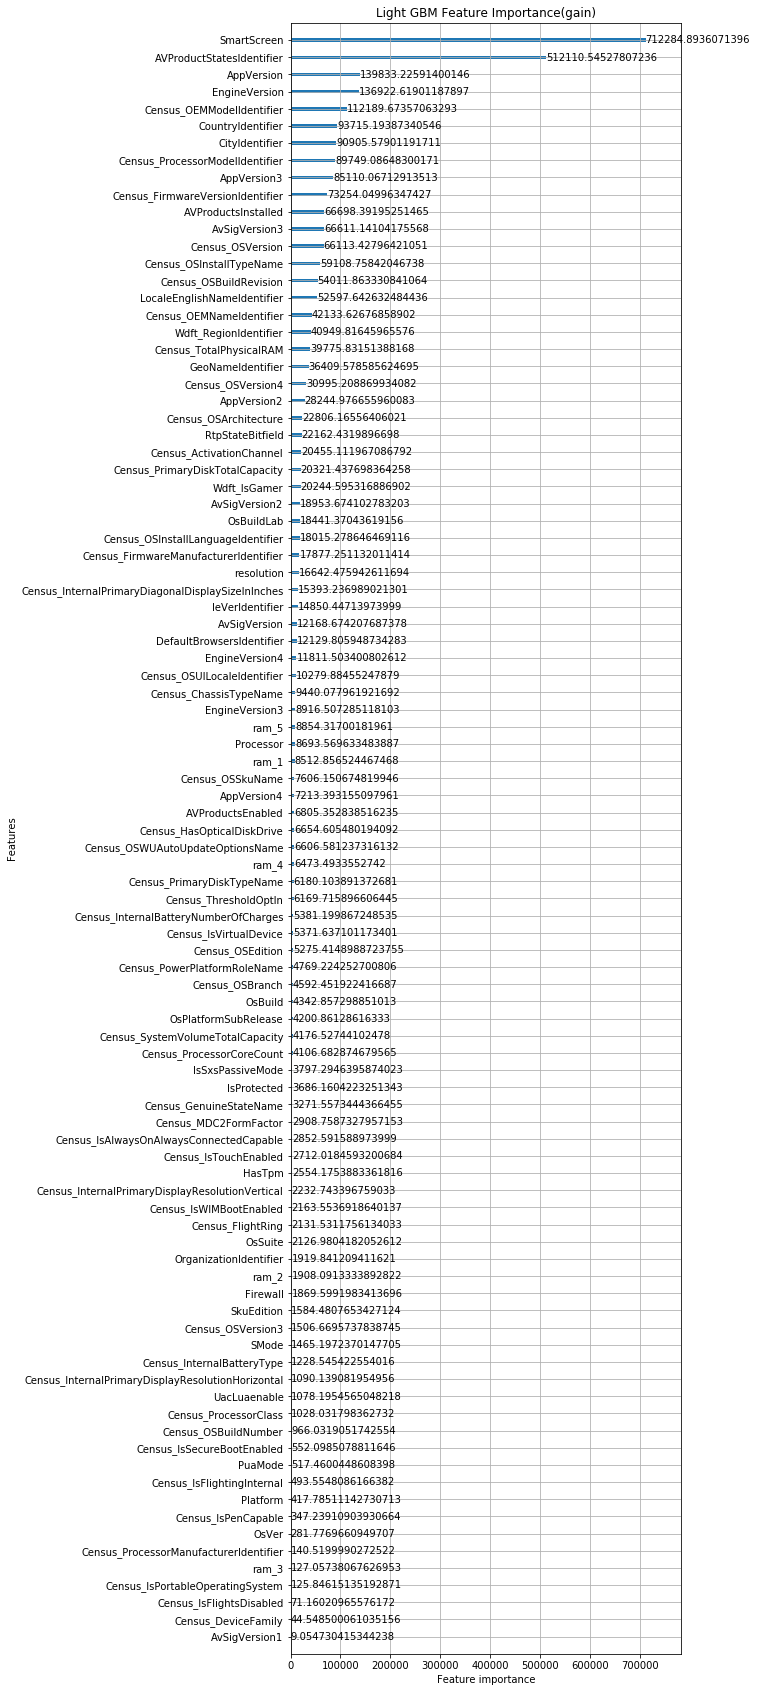

In [87]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [93]:
usecols = cols + ['resolution']
usecols.remove('Census_InternalPrimaryDisplayResolutionHorizontal')
usecols.remove('Census_InternalPrimaryDisplayResolutionVertical')
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [94]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.681264
[40]	valid_0's auc: 0.68897
[60]	valid_0's auc: 0.691695
[80]	valid_0's auc: 0.693661
[100]	valid_0's auc: 0.694843
[120]	valid_0's auc: 0.695317
[140]	valid_0's auc: 0.695907
[160]	valid_0's auc: 0.69625
[180]	valid_0's auc: 0.696561
[200]	valid_0's auc: 0.696978
[220]	valid_0's auc: 0.697311
[240]	valid_0's auc: 0.697829
[260]	valid_0's auc: 0.69821
[280]	valid_0's auc: 0.698339
[300]	valid_0's auc: 0.698444
[320]	valid_0's auc: 0.698539
[340]	valid_0's auc: 0.69699
[360]	valid_0's auc: 0.697231
[380]	valid_0's auc: 0.697307
[400]	valid_0's auc: 0.697508
[420]	valid_0's auc: 0.697583
Early stopping, best iteration is:
[336]	valid_0's auc: 0.69892


In [2]:
import pickle
#データ読みこみ
with open('/home/um003580/code/03102/train_preprocess.csv.pkl','rb') as f:
  train = pickle.load(f)
with open('/home/um003580/code/03102/test_preprocess.csv.pkl','rb') as f:
  test = pickle.load(f)

In [96]:
train.head()

ProductName EngineVersion AppVersion AvSigVersion IsBeta RtpStateBitfield  \
0           5             0          0            0      1                7   
1           5            57         30         6465      1                7   
2           5             0          0            0      1                7   
3           5             0          0            0      1                7   
4           5             0          0            0      1                7   

  IsSxsPassiveMode DefaultBrowsersIdentifier AVProductsInstalled  \
0                1                      2610                   2   
1                1                      2610                   2   
2                1                      2610                   2   
3                1                      2610                   2   
4                1                      2610                   2   

  AVProductsEnabled        ...        OsBuildLab_4 OsBuildLab_5_1  \
0                 2        ...                  17            230   
1                 2        ...                  17            230   
2                 2        ...                  17            230   
3                 2        ...                  17            230   
4                 2        ...                  17            230   

  OsBuildLab_5_2 CountryIdentifier_count Wdft_RegionIdentifier_count  \
0            180                  647634                   3251921.0   
1            180                  520839                    504963.0   
2            180                   76175                   2549287.0   
3            180                  166503                   2549287.0   
4            180                  122590                   2341900.0   

  Census_OSBranch_count AVProductStatesIdentifier LocaleEnglishNameIdentifier  \
0               7988302                     26978                          81   
1               7988302                     26978                         242   
2               7988302                     26978                         225   
3               7988302                     26978                          19   
4               7988302                     26978                         254   

  Census_FirmwareVersionIdentifier SmartScreen_count  
0                                0           6675413  
1                                0           6675413  
2                            39165           7729765  
3                             9298           1646629  
4                             9115           7729765  

[5 rows x 102 columns]

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921483 entries, 0 to 8921482
Columns: 102 entries, ProductName to SmartScreen_count
dtypes: category(90), float16(1), float32(4), float64(4), int64(3)
memory usage: 1.5 GB


In [98]:
cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [101]:
usecols = [x for x in cols if x not in ['EngineVersion1', 'EngineVersion2', 'AppVersion1', 'AvSigVersion4', 'Census_OSVersion2']]
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [99]:
# del train['MachineIdentifier'], test['MachineIdentifier']
# gc.collect()

X_fit = train.loc[train_index]
# y_fit = X_fit['HasDetections']
# del X_fit['HasDetections']

X_val = train.loc[valid_index]
# y_val = X_val['HasDetections']
# del X_val['HasDetections']

In [102]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.68144
[40]	valid_0's auc: 0.689714
[60]	valid_0's auc: 0.693461
[80]	valid_0's auc: 0.695038
[100]	valid_0's auc: 0.696389
[120]	valid_0's auc: 0.697067
[140]	valid_0's auc: 0.698396
[160]	valid_0's auc: 0.697469
[180]	valid_0's auc: 0.69773
[200]	valid_0's auc: 0.698196
[220]	valid_0's auc: 0.698444
[240]	valid_0's auc: 0.698708
[260]	valid_0's auc: 0.698716
[280]	valid_0's auc: 0.698831
[300]	valid_0's auc: 0.698955
[320]	valid_0's auc: 0.698867
[340]	valid_0's auc: 0.698878
[360]	valid_0's auc: 0.698932
[380]	valid_0's auc: 0.699166
[400]	valid_0's auc: 0.69929
[420]	valid_0's auc: 0.699289
[440]	valid_0's auc: 0.699418
[460]	valid_0's auc: 0.699316
[480]	valid_0's auc: 0.699356
[500]	valid_0's auc: 0.699418
[520]	valid_0's auc: 0.699437
[540]	valid_0's auc: 0.699414
[560]	valid_0's auc: 0.699526
[580]	valid_0's auc: 0.699619
[600]	valid_0's auc: 0.698773
[620]	valid_0's auc: 0.698515
[640]	valid_0'

Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

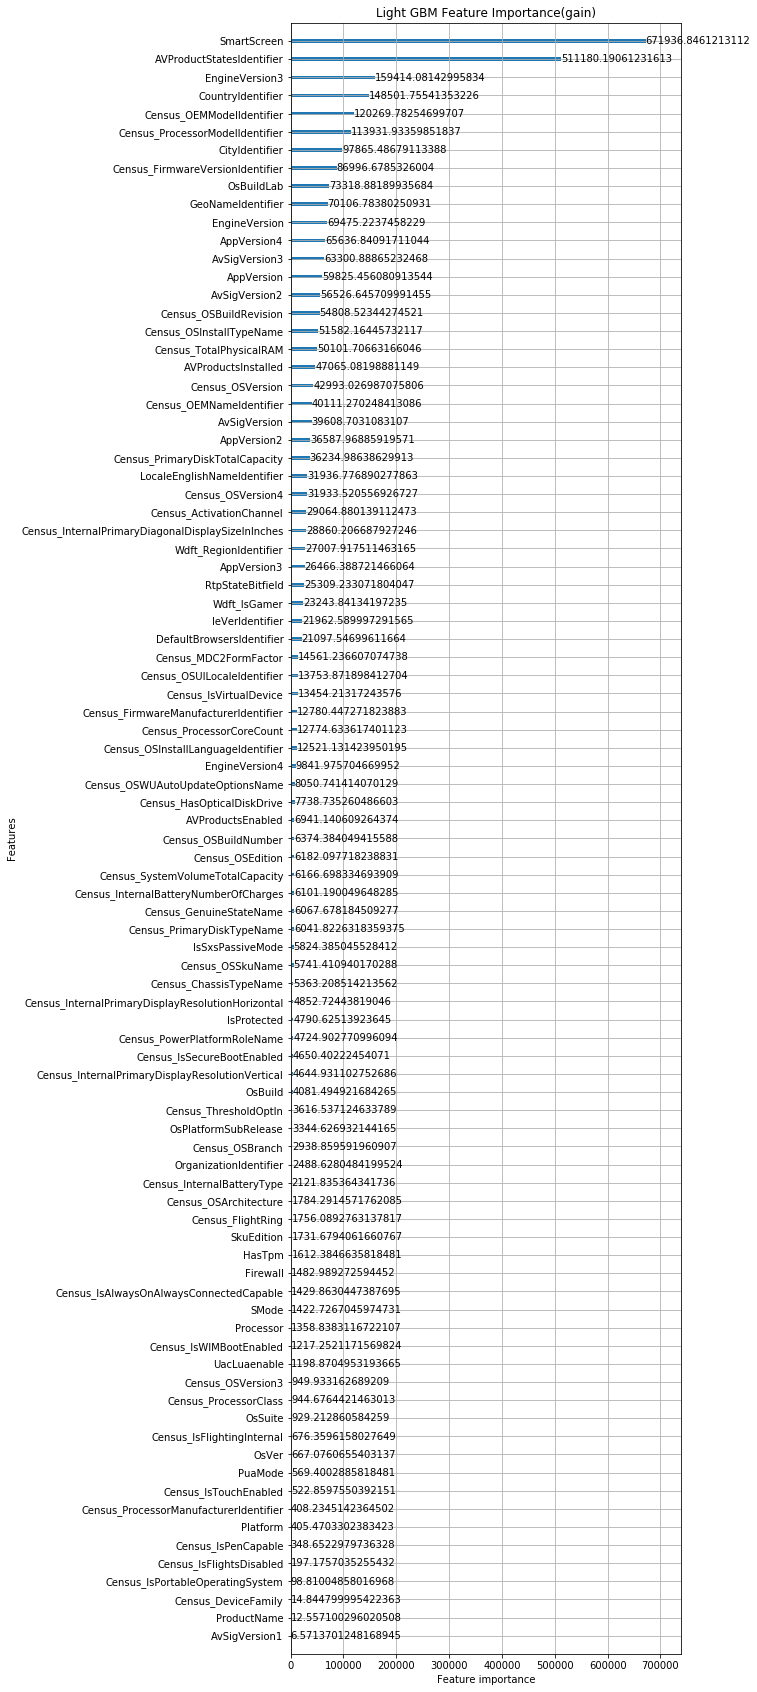

In [103]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [105]:
X_fit.head()

ProductName EngineVersion AppVersion AvSigVersion IsBeta RtpStateBitfield  \
0           5             0          0            0      1                7   
1           5            57         30         6465      1                7   
2           5             0          0            0      1                7   
3           5             0          0            0      1                7   
4           5             0          0            0      1                7   

  IsSxsPassiveMode DefaultBrowsersIdentifier AVProductsInstalled  \
0                1                      2610                   2   
1                1                      2610                   2   
2                1                      2610                   2   
3                1                      2610                   2   
4                1                      2610                   2   

  AVProductsEnabled        ...        OsBuildLab_4 OsBuildLab_5_1  \
0                 2        ...                  17            230   
1                 2        ...                  17            230   
2                 2        ...                  17            230   
3                 2        ...                  17            230   
4                 2        ...                  17            230   

  OsBuildLab_5_2 CountryIdentifier_count Wdft_RegionIdentifier_count  \
0            180                  647634                   3251921.0   
1            180                  520839                    504963.0   
2            180                   76175                   2549287.0   
3            180                  166503                   2549287.0   
4            180                  122590                   2341900.0   

  Census_OSBranch_count AVProductStatesIdentifier LocaleEnglishNameIdentifier  \
0               7988302                     26978                          81   
1               7988302                     26978                         242   
2               7988302                     26978                         225   
3               7988302                     26978                          19   
4               7988302                     26978                         254   

  Census_FirmwareVersionIdentifier SmartScreen_count  
0                                0           6675413  
1                                0           6675413  
2                            39165           7729765  
3                             9298           1646629  
4                             9115           7729765  

[5 rows x 102 columns]

In [106]:
param = {
    'max_depth': -1,
    'learning_rate': 0.2,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit,
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val,
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.685418
[40]	valid_0's auc: 0.690901
[60]	valid_0's auc: 0.694165
[80]	valid_0's auc: 0.69588
[100]	valid_0's auc: 0.69722
[120]	valid_0's auc: 0.697844
[140]	valid_0's auc: 0.698238
[160]	valid_0's auc: 0.69839
[180]	valid_0's auc: 0.698852
[200]	valid_0's auc: 0.699235
[220]	valid_0's auc: 0.699387
[240]	valid_0's auc: 0.699597
[260]	valid_0's auc: 0.699881
[280]	valid_0's auc: 0.700164
[300]	valid_0's auc: 0.700248
[320]	valid_0's auc: 0.700315
[340]	valid_0's auc: 0.700349
[360]	valid_0's auc: 0.700469
[380]	valid_0's auc: 0.700573
[400]	valid_0's auc: 0.700524
[420]	valid_0's auc: 0.700761
[440]	valid_0's auc: 0.700787
[460]	valid_0's auc: 0.700872
[480]	valid_0's auc: 0.700742
[500]	valid_0's auc: 0.70083
[520]	valid_0's auc: 0.700781
[540]	valid_0's auc: 0.700898
[560]	valid_0's auc: 0.700799
[580]	valid_0's auc: 0.700814
[600]	valid_0's auc: 0.700868
[620]	valid_0's auc: 0.700792
[640]	valid_0's

In [107]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit,
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val,
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.680716
[40]	valid_0's auc: 0.68627
[60]	valid_0's auc: 0.690283
[80]	valid_0's auc: 0.692901
[100]	valid_0's auc: 0.694765
[120]	valid_0's auc: 0.695567
[140]	valid_0's auc: 0.69666
[160]	valid_0's auc: 0.697407
[180]	valid_0's auc: 0.698292
[200]	valid_0's auc: 0.698711
[220]	valid_0's auc: 0.699211
[240]	valid_0's auc: 0.699579
[260]	valid_0's auc: 0.700014
[280]	valid_0's auc: 0.700311
[300]	valid_0's auc: 0.700284
[320]	valid_0's auc: 0.699865
[340]	valid_0's auc: 0.700163
[360]	valid_0's auc: 0.700318
[380]	valid_0's auc: 0.700483
[400]	valid_0's auc: 0.700615
[420]	valid_0's auc: 0.70081
[440]	valid_0's auc: 0.70084
[460]	valid_0's auc: 0.701004
[480]	valid_0's auc: 0.701137
[500]	valid_0's auc: 0.701224
[520]	valid_0's auc: 0.701345
[540]	valid_0's auc: 0.701481
[560]	valid_0's auc: 0.701514
[580]	valid_0's auc: 0.701662
[600]	valid_0's auc: 0.701701
[620]	valid_0's auc: 0.701723
[640]	valid_0's

In [108]:
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [109]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.672901
[40]	valid_0's auc: 0.682856
[60]	valid_0's auc: 0.687678
[80]	valid_0's auc: 0.691048
[100]	valid_0's auc: 0.692689
[120]	valid_0's auc: 0.694106
[140]	valid_0's auc: 0.695461
[160]	valid_0's auc: 0.696506
[180]	valid_0's auc: 0.697221
[200]	valid_0's auc: 0.697664
[220]	valid_0's auc: 0.698176
[240]	valid_0's auc: 0.698659
[260]	valid_0's auc: 0.698945
[280]	valid_0's auc: 0.699238
[300]	valid_0's auc: 0.699614
[320]	valid_0's auc: 0.699887
[340]	valid_0's auc: 0.699962
[360]	valid_0's auc: 0.700144
[380]	valid_0's auc: 0.700308
[400]	valid_0's auc: 0.700348
[420]	valid_0's auc: 0.700549
[440]	valid_0's auc: 0.700893
[460]	valid_0's auc: 0.701005
[480]	valid_0's auc: 0.701074
[500]	valid_0's auc: 0.701196
[520]	valid_0's auc: 0.701246
[540]	valid_0's auc: 0.701324
[560]	valid_0's auc: 0.701359
[580]	valid_0's auc: 0.701465
[600]	valid_0's auc: 0.701583
[620]	valid_0's auc: 0.701381
[640]	valid

In [5]:
with open('/home/um003580/input/train.csv.pkl','rb') as f:
  train_basic = pickle.load(f)

In [7]:
cols = [x for x in train_basic.columns if x not in ['MachineIdentifier', 'HasDetections']]
cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [10]:
train['HasDetections'] = train_basic['HasDetections']
X_fit = train.loc[train_index]
y_fit = X_fit['HasDetections']
del X_fit['HasDetections']

X_val = train.loc[valid_index]
y_val = X_val['HasDetections']
del X_val['HasDetections']

In [16]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[cols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[cols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

/home/um003580/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.660785
[40]	valid_0's auc: 0.674856
[60]	valid_0's auc: 0.682167
[80]	valid_0's auc: 0.682773
[100]	valid_0's auc: 0.68697
[120]	valid_0's auc: 0.691418
[140]	valid_0's auc: 0.693698
[160]	valid_0's auc: 0.694819
[180]	valid_0's auc: 0.695742
[200]	valid_0's auc: 0.695886
[220]	valid_0's auc: 0.695739
[240]	valid_0's auc: 0.695562
[260]	valid_0's auc: 0.695997
[280]	valid_0's auc: 0.696511
[300]	valid_0's auc: 0.697005
[320]	valid_0's auc: 0.696484
[340]	valid_0's auc: 0.69702
[360]	valid_0's auc: 0.696224
[380]	valid_0's auc: 0.696538
[400]	valid_0's auc: 0.696576
Early stopping, best iteration is:
[317]	valid_0's auc: 0.697365


In [ ]:
#データ読みこみ
with open('/home/um003580/code/0307/train_preprocess.csv.pkl','rb') as f:
  train_basic = pickle.load(f)

In [29]:
cols = [x for x in train_basic.columns if x not in ['MachineIdentifier', 'HasDetections']]
same_cols = ['EngineVersion1', 'EngineVersion2', 'AppVersion1', 'AvSigVersion4', 'Census_OSVersion2']
obl = ['OsBuildLab_1','OsBuildLab_2','OsBuildLab_3','OsBuildLab_4','OsBuildLab_5_1','OsBuildLab_5_2']
cols = [x for x in cols if x not in (same_cols + obl)]

In [30]:
cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [31]:
usecols = cols + obl
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [32]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.655951
[40]	valid_0's auc: 0.678163
[60]	valid_0's auc: 0.684442
[80]	valid_0's auc: 0.687397
[100]	valid_0's auc: 0.690856
[120]	valid_0's auc: 0.692742
[140]	valid_0's auc: 0.694
[160]	valid_0's auc: 0.695008
[180]	valid_0's auc: 0.695796
[200]	valid_0's auc: 0.696392
[220]	valid_0's auc: 0.696919
[240]	valid_0's auc: 0.697172
[260]	valid_0's auc: 0.697504
[280]	valid_0's auc: 0.697657
[300]	valid_0's auc: 0.698011
[320]	valid_0's auc: 0.697984
[340]	valid_0's auc: 0.698148
[360]	valid_0's auc: 0.697993
[380]	valid_0's auc: 0.697891
[400]	valid_0's auc: 0.697992
[420]	valid_0's auc: 0.698147
[440]	valid_0's auc: 0.69797
Early stopping, best iteration is:
[348]	valid_0's auc: 0.698222


In [33]:
usecols = cols + ['CountryIdentifier_count', 'Wdft_RegionIdentifier_count','Census_OSBranch_count']
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [34]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.672017
[40]	valid_0's auc: 0.682473
[60]	valid_0's auc: 0.688655
[80]	valid_0's auc: 0.69223
[100]	valid_0's auc: 0.693498
[120]	valid_0's auc: 0.69506
[140]	valid_0's auc: 0.696192
[160]	valid_0's auc: 0.696667
[180]	valid_0's auc: 0.697239
[200]	valid_0's auc: 0.697777
[220]	valid_0's auc: 0.698407
[240]	valid_0's auc: 0.698731
[260]	valid_0's auc: 0.698914
[280]	valid_0's auc: 0.699154
[300]	valid_0's auc: 0.699465
[320]	valid_0's auc: 0.699731
[340]	valid_0's auc: 0.69981
[360]	valid_0's auc: 0.700161
[380]	valid_0's auc: 0.700265
[400]	valid_0's auc: 0.700426
[420]	valid_0's auc: 0.70057
[440]	valid_0's auc: 0.70071
[460]	valid_0's auc: 0.700148
[480]	valid_0's auc: 0.700192
[500]	valid_0's auc: 0.700372
[520]	valid_0's auc: 0.700518
[540]	valid_0's auc: 0.700713
[560]	valid_0's auc: 0.700881
[580]	valid_0's auc: 0.701024
[600]	valid_0's auc: 0.701138
[620]	valid_0's auc: 0.700553
[640]	valid_0's 

In [35]:
usecols = cols + ['SmartScreen_count']
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [38]:
len(usecols)

93

In [36]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.668366
[40]	valid_0's auc: 0.68104
[60]	valid_0's auc: 0.68809
[80]	valid_0's auc: 0.690097
[100]	valid_0's auc: 0.69242
[120]	valid_0's auc: 0.693674
[140]	valid_0's auc: 0.694851
[160]	valid_0's auc: 0.695618
[180]	valid_0's auc: 0.696265
[200]	valid_0's auc: 0.696659
[220]	valid_0's auc: 0.697202
[240]	valid_0's auc: 0.697559
[260]	valid_0's auc: 0.698077
[280]	valid_0's auc: 0.698413
[300]	valid_0's auc: 0.698661
[320]	valid_0's auc: 0.698892
[340]	valid_0's auc: 0.698922
[360]	valid_0's auc: 0.699164
[380]	valid_0's auc: 0.699348
[400]	valid_0's auc: 0.699571
[420]	valid_0's auc: 0.699682
[440]	valid_0's auc: 0.699826
[460]	valid_0's auc: 0.700004
[480]	valid_0's auc: 0.700057
[500]	valid_0's auc: 0.70003
[520]	valid_0's auc: 0.700098
[540]	valid_0's auc: 0.700109
[560]	valid_0's auc: 0.700253
[580]	valid_0's auc: 0.699511
[600]	valid_0's auc: 0.699632
[620]	valid_0's auc: 0.69976
[640]	valid_0's 

In [37]:
X_fit.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta',
       'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled',
       ...
       'OsBuildLab_4', 'OsBuildLab_5_1', 'OsBuildLab_5_2',
       'CountryIdentifier_count', 'Wdft_RegionIdentifier_count',
       'Census_OSBranch_count', 'AVProductStatesIdentifier',
       'LocaleEnglishNameIdentifier', 'Census_FirmwareVersionIdentifier',
       'SmartScreen_count'],
      dtype='object', length=102)

In [39]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit,
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val,
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.680716
[40]	valid_0's auc: 0.68627
[60]	valid_0's auc: 0.690283
[80]	valid_0's auc: 0.692901
[100]	valid_0's auc: 0.694765
[120]	valid_0's auc: 0.695567
[140]	valid_0's auc: 0.69666
[160]	valid_0's auc: 0.697407
[180]	valid_0's auc: 0.698292
[200]	valid_0's auc: 0.698711
[220]	valid_0's auc: 0.699211
[240]	valid_0's auc: 0.699579
[260]	valid_0's auc: 0.700014
[280]	valid_0's auc: 0.700311
[300]	valid_0's auc: 0.700284
[320]	valid_0's auc: 0.699865
[340]	valid_0's auc: 0.700163
[360]	valid_0's auc: 0.700318
[380]	valid_0's auc: 0.700483
[400]	valid_0's auc: 0.700615
[420]	valid_0's auc: 0.70081
[440]	valid_0's auc: 0.70084
[460]	valid_0's auc: 0.701004
[480]	valid_0's auc: 0.701137
[500]	valid_0's auc: 0.701224
[520]	valid_0's auc: 0.701345
[540]	valid_0's auc: 0.701481
[560]	valid_0's auc: 0.701514
[580]	valid_0's auc: 0.701662
[600]	valid_0's auc: 0.701701
[620]	valid_0's auc: 0.701723
[640]	valid_0's

In [40]:
usecols = cols + ['CountryIdentifier_count', 'Wdft_RegionIdentifier_count','Census_OSBranch_count', 'SmartScreen_count']
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [42]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.676456
[40]	valid_0's auc: 0.685965
[60]	valid_0's auc: 0.690463
[80]	valid_0's auc: 0.692926
[100]	valid_0's auc: 0.69451
[120]	valid_0's auc: 0.695796
[140]	valid_0's auc: 0.696792
[160]	valid_0's auc: 0.697337
[180]	valid_0's auc: 0.697892
[200]	valid_0's auc: 0.698029
[220]	valid_0's auc: 0.698562
[240]	valid_0's auc: 0.699094
[260]	valid_0's auc: 0.699262
[280]	valid_0's auc: 0.699532
[300]	valid_0's auc: 0.699618
[320]	valid_0's auc: 0.699659
[340]	valid_0's auc: 0.699892
[360]	valid_0's auc: 0.699853
[380]	valid_0's auc: 0.699997
[400]	valid_0's auc: 0.700073
[420]	valid_0's auc: 0.700111
[440]	valid_0's auc: 0.700235
[460]	valid_0's auc: 0.700361
[480]	valid_0's auc: 0.700465
[500]	valid_0's auc: 0.700519
[520]	valid_0's auc: 0.700654
[540]	valid_0's auc: 0.700732
[560]	valid_0's auc: 0.700737
[580]	valid_0's auc: 0.70088
[600]	valid_0's auc: 0.700967
[620]	valid_0's auc: 0.701046
[640]	valid_0

In [43]:
usecols = cols + obl + ['CountryIdentifier_count', 'Wdft_RegionIdentifier_count','Census_OSBranch_count', 'SmartScreen_count']
usecols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [45]:
len(usecols)

102

In [46]:
len(X_fit.columns)

102

In [44]:
param = {
    'max_depth': -1,
    'learning_rate': 0.1,
    'colsample_bytree': 0.2,
    'objective': 'binary',
    'n_jobs': -1,
    'importance_type': 'gain',
    'metric': 'None'
}
trn_data = lgb.Dataset(X_fit[usecols],
                       label=y_fit,
#                        categorical_feature = categorical_columns
                      )
val_data = lgb.Dataset(X_val[usecols],
                       label=y_val,
#                        categorical_feature = categorical_columns
                      )

num_round = 10000
clf = lgb.train(param,
                trn_data,
                num_round,
                valid_sets = [val_data],
                verbose_eval = 20,
                early_stopping_rounds = 100,
                feval=eval_auc)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.673115
[40]	valid_0's auc: 0.682811
[60]	valid_0's auc: 0.688245
[80]	valid_0's auc: 0.690717
[100]	valid_0's auc: 0.692632
[120]	valid_0's auc: 0.694262
[140]	valid_0's auc: 0.695705
[160]	valid_0's auc: 0.69659
[180]	valid_0's auc: 0.697218
[200]	valid_0's auc: 0.697623
[220]	valid_0's auc: 0.698005
[240]	valid_0's auc: 0.698391
[260]	valid_0's auc: 0.698768
[280]	valid_0's auc: 0.699006
[300]	valid_0's auc: 0.699232
[320]	valid_0's auc: 0.699355
[340]	valid_0's auc: 0.699439
[360]	valid_0's auc: 0.69948
[380]	valid_0's auc: 0.699727
[400]	valid_0's auc: 0.699789
[420]	valid_0's auc: 0.699995
[440]	valid_0's auc: 0.700135
[460]	valid_0's auc: 0.70022
[480]	valid_0's auc: 0.700424
[500]	valid_0's auc: 0.700607
[520]	valid_0's auc: 0.700667
[540]	valid_0's auc: 0.700572
[560]	valid_0's auc: 0.700928
[580]	valid_0's auc: 0.700929
[600]	valid_0's auc: 0.701041
[620]	valid_0's auc: 0.701048
[640]	valid_0'

Text(0.5, 1.0, 'Light GBM Feature Importance(gain)')

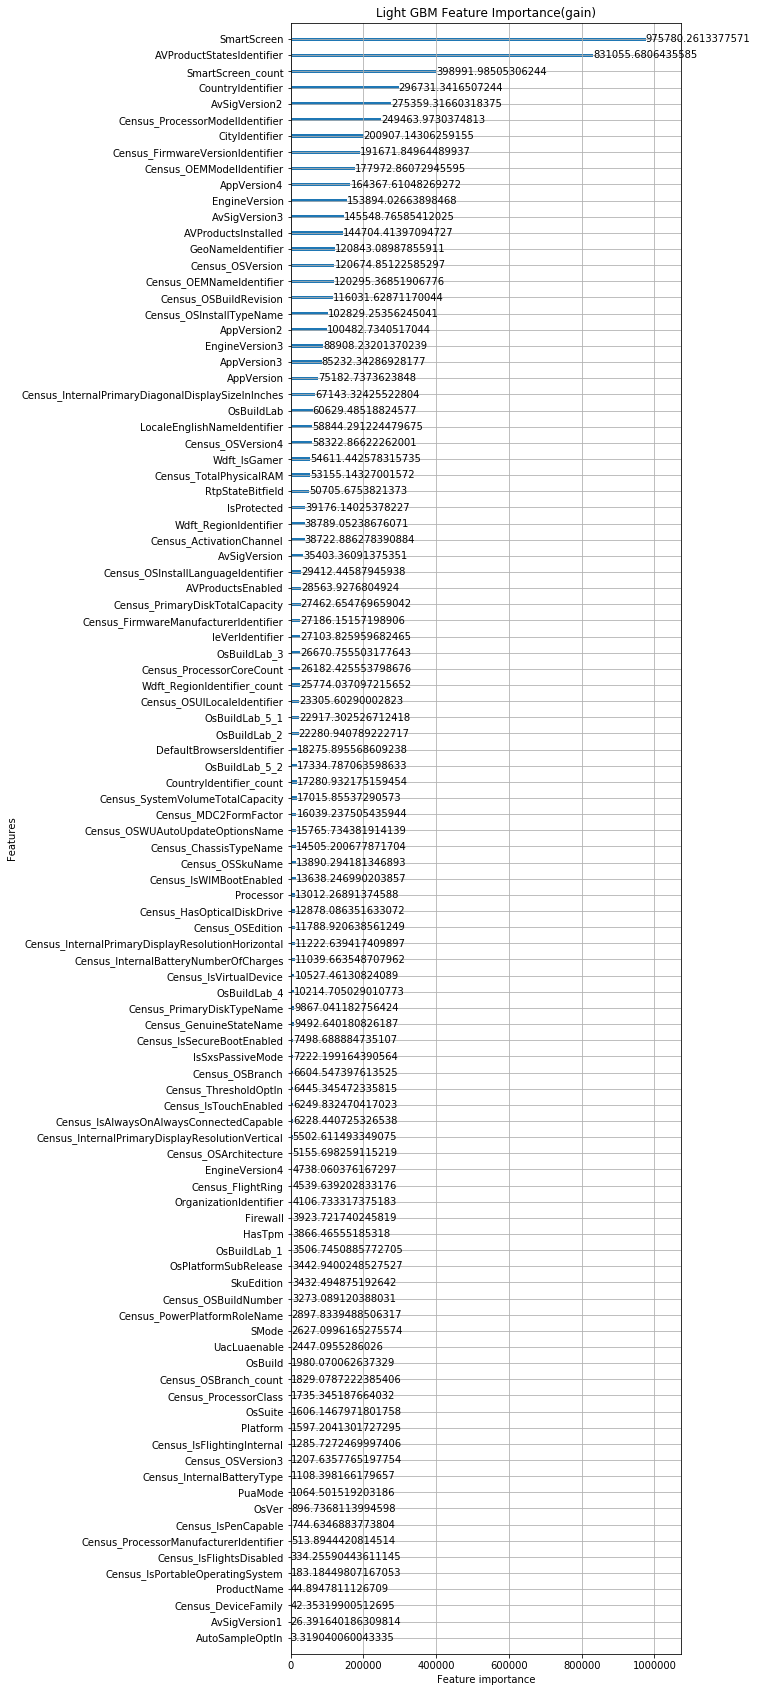

In [47]:
# feature importance
f, ax = plt.subplots(figsize=[7, 30])
lgb.plot_importance(clf, max_num_features=300, ax=ax, importance_type='gain')
plt.title("Light GBM Feature Importance(gain)")

In [ ]:
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.680716
[40]	valid_0's auc: 0.68627
[60]	valid_0's auc: 0.690283
[80]	valid_0's auc: 0.692901
[100]	valid_0's auc: 0.694765
[120]	valid_0's auc: 0.695567
[140]	valid_0's auc: 0.69666
[160]	valid_0's auc: 0.697407
[180]	valid_0's auc: 0.698292
[200]	valid_0's auc: 0.698711
[220]	valid_0's auc: 0.699211
[240]	valid_0's auc: 0.699579
[260]	valid_0's auc: 0.700014
[280]	valid_0's auc: 0.700311
[300]	valid_0's auc: 0.700284
[320]	valid_0's auc: 0.699865
[340]	valid_0's auc: 0.700163
[360]	valid_0's auc: 0.700318
[380]	valid_0's auc: 0.700483
[400]	valid_0's auc: 0.700615
[420]	valid_0's auc: 0.70081
[440]	valid_0's auc: 0.70084
[460]	valid_0's auc: 0.701004
[480]	valid_0's auc: 0.701137
[500]	valid_0's auc: 0.701224
[520]	valid_0's auc: 0.701345
[540]	valid_0's auc: 0.701481
[560]	valid_0's auc: 0.701514
[580]	valid_0's auc: 0.701662
[600]	valid_0's auc: 0.701701
[620]	valid_0's auc: 0.701723
[640]	valid_0's auc: 0.701801
[660]	valid_0's auc: 0.701814
[680]	valid_0's auc: 0.701949
[700]	valid_0's auc: 0.701969
[720]	valid_0's auc: 0.702163
[740]	valid_0's auc: 0.702206
[760]	valid_0's auc: 0.702301
[780]	valid_0's auc: 0.702369
[800]	valid_0's auc: 0.702423
[820]	valid_0's auc: 0.702479
[840]	valid_0's auc: 0.702529
[860]	valid_0's auc: 0.702563
[880]	valid_0's auc: 0.702588
[900]	valid_0's auc: 0.702608
[920]	valid_0's auc: 0.702579
[940]	valid_0's auc: 0.702601
[960]	valid_0's auc: 0.702639
[980]	valid_0's auc: 0.702246
Early stopping, best iteration is:
[897]	valid_0's auc: 0.702677

In [ ]:
numeric 0.7014
clean smartscreen 0.701655
osbuild 

全部のせ　0.7026

In [ ]:
todo
-19
前処理のしきい値をかえる
sscleaning検証

takeshi_count
kernel multiple count
avsigver2_int

-24

特徴量変形
特徴量選択

-26
sparce
5foldcv

朝
blend